In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
from tqdm import tqdm
from keras.models import Model

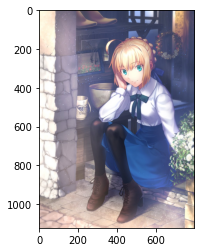

In [3]:
image_rin = cv.imread('/content/drive/MyDrive/DataSet/Rin Tohsaka/8b2d2b0f2efb37925f40cf85d3248ff8.png')
image_rin = cv.cvtColor(image_rin, cv.COLOR_BGR2RGB)
plt.imshow(image_rin)
image_saber = cv.imread('/content/drive/MyDrive/DataSet/Saber/20210904_062250.jpg')
image_saber = cv.cvtColor(image_saber, cv.COLOR_BGR2RGB)
plt.imshow(image_saber)

In [4]:
data_dir = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/DataSet')
data_dir = pathlib.Path('/content/drive/MyDrive/DataSet')
print(data_dir)
print(os.path.abspath(data_dir))

Found 410 files belonging to 4 classes.
/content/drive/MyDrive/DataSet
/content/drive/MyDrive/DataSet


In [5]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

418


In [6]:
Rins = list(data_dir.glob('Rin Tohsaka/*'))
Ereshkigal = list(data_dir.glob('Ereshkigal/*'))
Ishtar = list(data_dir.glob('Ishtar/*'))
Saber = list(data_dir.glob('Saber/*'))

In [7]:
total = Rins + Ereshkigal + Ishtar + Saber

In [8]:
x = 100000
y = 100000
dslen = len(total)

In [9]:
for i in tqdm(range(dslen)):
  t = PIL.Image.open(str(total[i]))
  xm, ym = t.size
  if xm < x:
    x = xm
  if ym < y:
    y = ym

100%|██████████| 418/418 [01:23<00:00,  4.99it/s]


In [10]:
print(x)
print(y)

292
298


In [11]:
batch_size = 16
img_height = 290
img_width = 290

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 410 files belonging to 4 classes.
Using 328 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 410 files belonging to 4 classes.
Using 82 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['Ereshkigal', 'Ishtar', 'Rin Tohsaka', 'Saber']


In [15]:
Eriimg = PIL.Image.open(str(Ereshkigal[0]))
Rinimg = PIL.Image.open(str(Rins[0]))
Saberimg = PIL.Image.open(str(Saber[0]))
Ishtarimg = PIL.Image.open(str(Ishtar[0]))

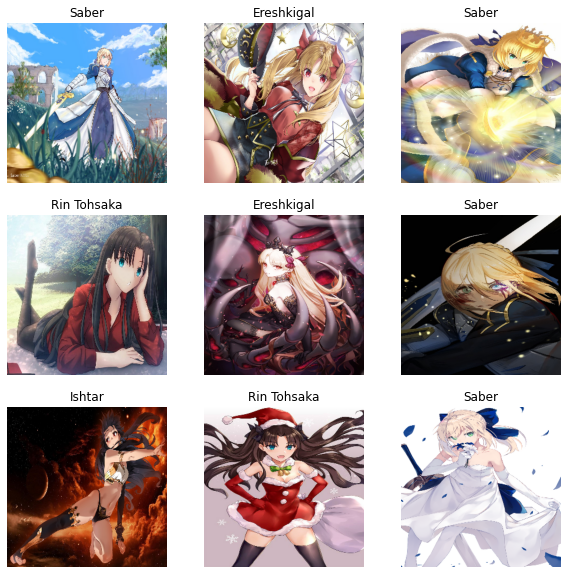

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 290, 290, 3)
(16,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 290, 290, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 290, 290, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 290, 290, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 145, 145, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 32)       0         
 2D)                                                  

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
21/21 [==============================] - 16s 249ms/step - loss: 1.9622 - accuracy: 0.3171 - val_loss: 1.3072 - val_accuracy: 0.3049
Epoch 2/10
21/21 [==============================] - 1s 65ms/step - loss: 1.2320 - accuracy: 0.3780 - val_loss: 1.2982 - val_accuracy: 0.3049
Epoch 3/10
21/21 [==============================] - 1s 64ms/step - loss: 1.1184 - accuracy: 0.4451 - val_loss: 1.1656 - val_accuracy: 0.4146
Epoch 4/10
21/21 [==============================] - 1s 64ms/step - loss: 1.0709 - accuracy: 0.5305 - val_loss: 1.1845 - val_accuracy: 0.5000
Epoch 5/10
21/21 [==============================] - 1s 65ms/step - loss: 1.0523 - accuracy: 0.5884 - val_loss: 1.0328 - val_accuracy: 0.5488
Epoch 6/10
21/21 [==============================] - 1s 65ms/step - loss: 0.8969 - accuracy: 0.6006 - val_loss: 1.0526 - val_accuracy: 0.5488
Epoch 7/10
21/21 [==============================] - 1s 66ms/step - loss: 0.8205 - accuracy: 0.6768 - val_loss: 1.0868 - val_accuracy: 0.5976
Epoch 8/10


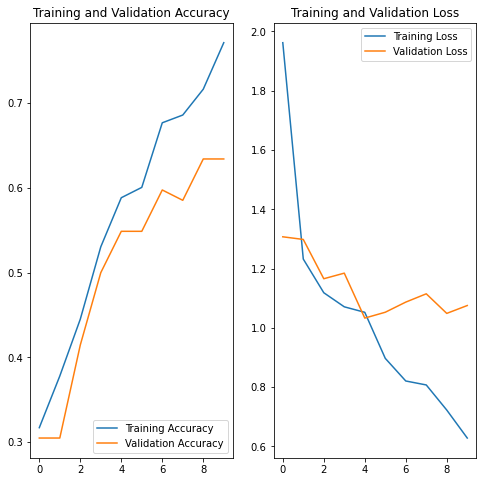

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
from google.colab import files
file_to_predict = files.upload()

Saving 20211220_180911.jpg to 20211220_180911.jpg


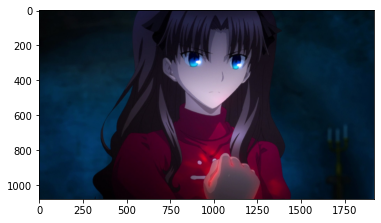

In [31]:
for file_ in file_to_predict:
    image_to_predict = cv.imread(file_,cv.IMREAD_COLOR)
    plt.imshow(cv.cvtColor(image_to_predict, cv.COLOR_BGR2RGB))
    plt.show()

In [32]:
img = cv.resize(image_to_predict, (290,290))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Rin Tohsaka with a 45.69 percent confidence.


In [33]:
layer_names = [layer.name for layer in model.layers]
layer_names.pop(0)
layer_names.pop(0)
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout',
 'flatten',
 'dense',
 'dense_1']

In [34]:
layer_outputs = [layer.output for layer in model.layers]
layer_outputs.pop(0)
layer_outputs.pop(0)

<KerasTensor: shape=(None, 290, 290, 3) dtype=float32 (created by layer 'rescaling_1')>

In [35]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

In [36]:
input = image_rin.copy()
input = cv.resize(input, (290, 290))
input = input.reshape((1,) + input.shape)                   

In [37]:
feature_maps = feature_map_model.predict(input)

In [38]:
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

The shape of the conv2d is =======>> (1, 290, 290, 16)
The shape of the max_pooling2d is =======>> (1, 145, 145, 16)
The shape of the conv2d_1 is =======>> (1, 145, 145, 32)
The shape of the max_pooling2d_1 is =======>> (1, 72, 72, 32)
The shape of the conv2d_2 is =======>> (1, 72, 72, 64)
The shape of the max_pooling2d_2 is =======>> (1, 36, 36, 64)
The shape of the dropout is =======>> (1, 36, 36, 64)
The shape of the flatten is =======>> (1, 82944)
The shape of the dense is =======>> (1, 128)
The shape of the dense_1 is =======>> (1, 4)


In [39]:
activation = feature_map_model(input)
a = activation[0]
a.shape

TensorShape([1, 290, 290, 16])

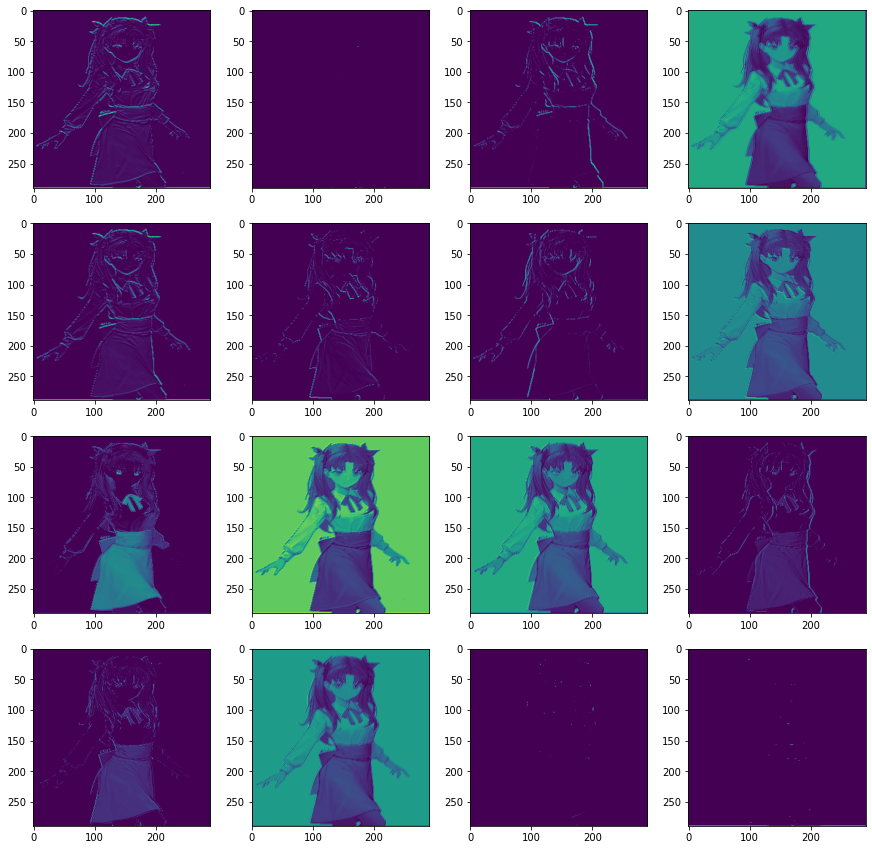

In [41]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(a[0,:, :, i])
plt.show()

In [48]:
model.layers

In [75]:
blocks = [ 2, 3, 4 , 5, 6, 7, 10]
outputs = [model.layers[i].output for i in blocks]

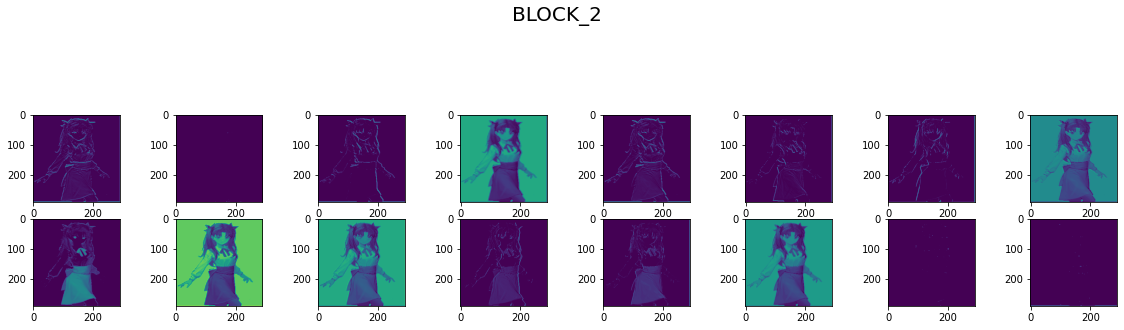

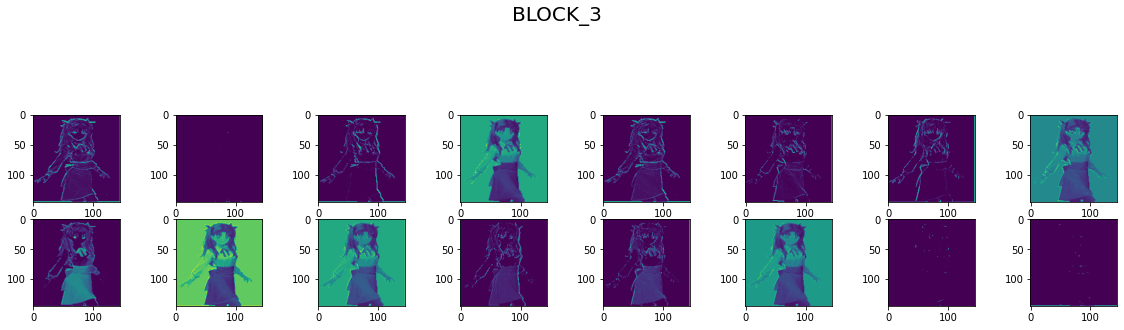

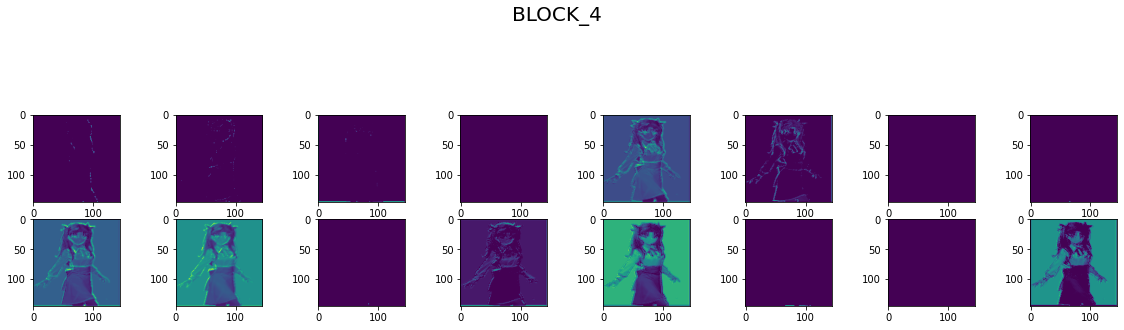

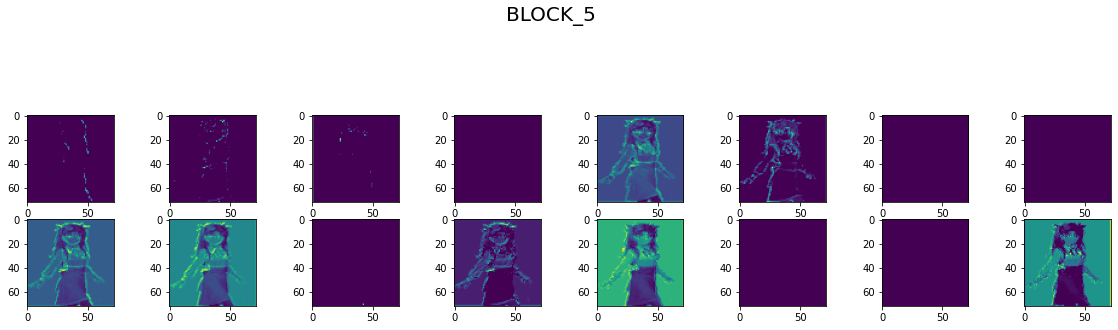

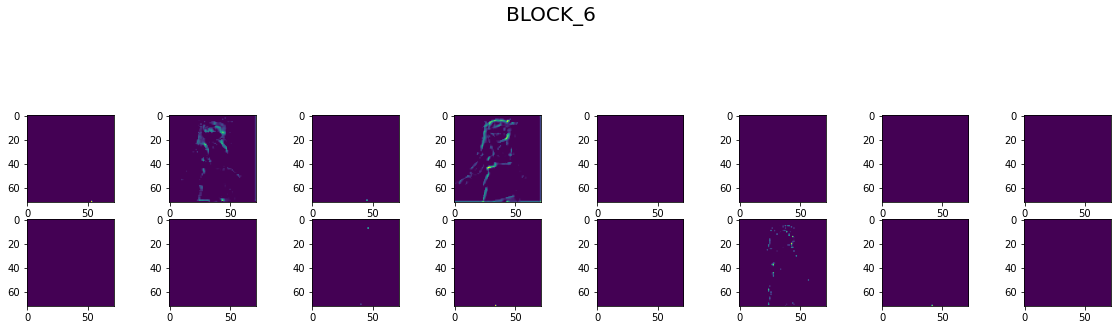

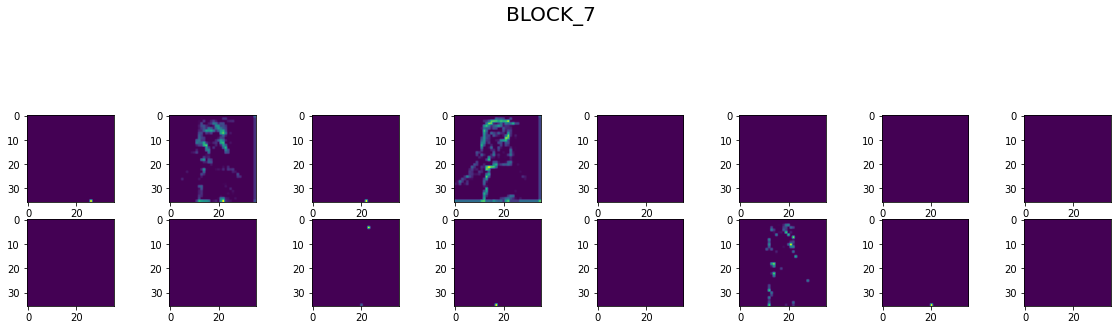

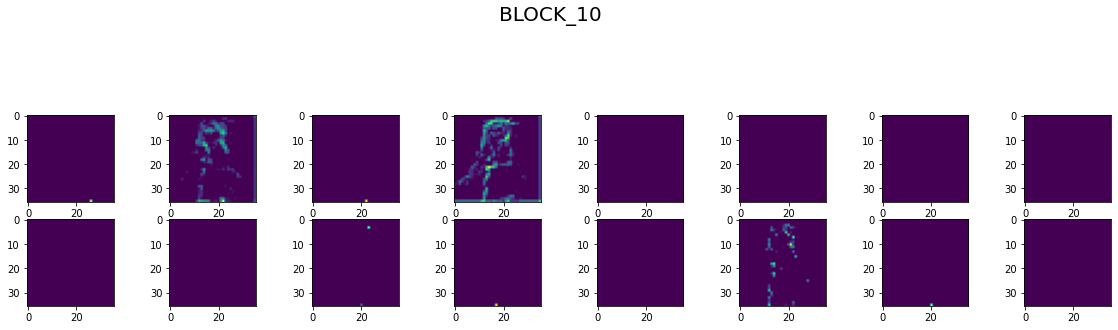

In [76]:
for i,fmap in zip(blocks,feature_maps):
    fig = plt.figure(figsize=(20,15))
    fig.suptitle("BLOCK_{}".format(i) , fontsize=20)
    for i in range(1,a.shape[3]+1):
        plt.subplot(8,8,i)
        plt.imshow(fmap[0,:,:,i-1])
    
plt.show()